# Fake _Fake_ News?
Kevin Chang, Hariz Hisham, Thuy Le, Tam Nguyen, Qing Zhang<br>
Santa Clara University

The goal of this exercise is to determine whether fake news and factual news sites can be told apart by contemporary algorithms.

This analysis is an extension of prior [research](https://arxiv.org/abs/1810.01765) conducted at MIT. The data for this research can be retrieved [here](https://github.com/ramybaly/News-Media-Reliability/). Additionally, this project was inspired by [prior work](http://web.stanford.edu/~mattm401/docs/2018-Golbeck-WebSci-FakeNewsVsSatire.pdf) done by Golbeck et al (2018).

Note: In this analysis, we are relying 100% on the output of the algorithm to determine if a news site is 'fake news' or 'reall'. We provide a caveat and explanation as to why this approach may not be completely sound (or in fact, safe) IRL.

This project was done in part as a collective effort with the Markkula Center for Applied Ethics at Santa Clara University. For more information on the great work covered by the Markkula Center, click [here](https://www.scu.edu/ethics/).

Special thanks to Sanjiv Das and Subbu Vincent for their support and guidance on this project.

Keywords: Fake news, classification, support vector machine

## Environment Setup

In [0]:
import pandas as pd
import numpy as np
import nltk

import warnings
warnings.filterwarnings('ignore')

In [0]:
### DON'T RUN UNLESS ON GOOGLE COLAB ###
from google.colab import drive
drive.mount('/content/drive')
### DON'T RUN UNLESS ON GOOGLE COLAB ###

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Read in the file

In [0]:
file_path = '/content/drive/Shared drives/Machine Learning Project/Final Project/'
df = pd.read_csv(file_path + 'data/corpus_full_text_v2.csv',
                 index_col = False)

df = df[['source_url','source_url_processed','URL','fact','bias','article_1',
         'article_2','article_3','article_4','article_5']].fillna('')

Below, we transform the 5 columns of news articles into 5 rows. This will generate a unique row for each article, but with the same featureset if the articles come from the same newsite. 

e.g.

We expect CNN to have 5 rows of similar features but containing a different article for each row.

In [0]:
cols = ['article_1','article_2','article_3','article_4','article_5']
# transform the five article columns by transposing; articles should be vertical
stack = pd.DataFrame(df[cols]).stack().reset_index()

stack = stack.drop(['level_0','level_1'], axis = 1)

In [0]:
# drop articles from main dataframe
df = df.drop(columns = cols)
# repeat each news source 5 times since each source has 5 articles extracted
df2 = df.loc[df.index.repeat(5)].reset_index(drop = True)

In [0]:
# concatenate repeated df and transformed articles
if len(df2) == len(stack):
  me = pd.concat([df2,stack], axis = 1)
  me = me.rename({0 : 'article'}, axis = 'columns')
else:
  print('Attempted to merge data frames of different len!')

In [0]:
# Check that we did the transformation correctly
print(me.shape)
print(me.head(6))

(4595, 6)
                       source_url  ...                                            article
0    http://www.villagevoice.com/  ...  This Thing Called…\n\nJune 25, 1979\n\nI am a ...
1    http://www.villagevoice.com/  ...  The Closet Syndrome: Gays in Hollywood\n\nJune...
2    http://www.villagevoice.com/  ...  Way back in the 1980s, Lynn Yaeger started wor...
3    http://www.villagevoice.com/  ...  Fred McDarrah\n\nFrank O’Hara: He Made Things ...
4    http://www.villagevoice.com/  ...  From The Archives When the Lights Went Out in ...
5  https://insideclimatenews.org/  ...  InsideClimate News won the 2013 Pulitzer Prize...

[6 rows x 6 columns]


## Instantiate text cleaning functions

In [0]:
# Download necessary extensions from nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import string

def removePuncStr(s):
  assert type(s) == str
  try:
    for c in string.punctuation:
        s = s.replace(c," ")
    return s
  except:
    print("Unable to replace punctuations with empty space.")

def removePunc(string):
  try:
    return [removePuncStr(h) for h in string]
  except:
    print("Punctuation removal failed.")
  
def removeNumbersStr(s):
  assert type(s) == str
  try:
    for c in range(10):
        n = str(c)
        s = s.replace(n," ")
    return s
  except:
    print("Unable to remove numbers from string.")

def removeNumbers(text_array):
    return [removeNumbersStr(h) for h in text_array]

def stemText(text_array):
    stemmed_text = []
    for h in text_array:
        words = word_tokenize(h)
        h2 = ''
        for w in words:
            h2 = h2 + ' ' + PorterStemmer().stem(w)
        stemmed_text.append(h2)
    return stemmed_text
  
def stopText(text_array):
    stop_words = set(stopwords.words('english'))
    stopped_text = []
    for h in text_array:
        words = word_tokenize(h)
        h2 = ''
        for w in words:
            if w not in stop_words:
                h2 = h2 + ' ' + w
        stopped_text.append(h2)
    return stopped_text
  
def lemmText(text_array):
    WNlemmatizer = WordNetLemmatizer()
    lemmatized_text = []
    for h in text_array:
        words = word_tokenize(h) 
        h2 = ''
        for w in words:
            h2 = h2 + ' ' + WNlemmatizer.lemmatize(w)
        lemmatized_text.append(h2)
    return lemmatized_text

def clean_raw(text):
  text= BeautifulSoup(text, 'lxml').get_text()
  text = text.splitlines()
  text = lemmText(stopText(removeNumbers(removePunc(text))))
  return text

def drop_empty_article(article):
  if not article:
    return None
  else:
    return article[0]

In [0]:
# Apply the clean_raw function onto each row of our data set and append results
# to a new column called 'article_clean'. This will be used for NLP downstream
me['stripped'] = me['article'].apply(lambda x : x.replace("\n"," ").lower())
me['cleaned'] = me['stripped'].apply(clean_raw)
me['article_clean'] = me['cleaned'].apply(lambda article : drop_empty_article(article))

# Drop rows containing N/A articles after transformation
me = me[me['article_clean'].notna()].reset_index(drop=True)
me = me[me['article_clean'].str.split(' ').str.len() > 50]\
      .reset_index(drop=True)

## Feature Engineering

In [0]:
# Get length of each article after cleaning
me['art_len'] = me['article_clean'].str.split(' ').str.len()
# Get domain name of each news site
me['domain'] = me['source_url_processed'].str.split('.')\
                .apply(lambda x : x[1])

## Modeling

### Defining Target Variable

In [0]:
# Define fake news as news sites with 'LOW' factual rating
me['fact_bin'] = me['fact'].map({'LOW': 0, 'MIXED': 0, 'HIGH': 1})

In [0]:
from sklearn.model_selection import train_test_split
#from imblearn.combine import SMOTEENN
from sklearn.metrics import confusion_matrix, recall_score

# Define the featureset and convert to string
# We will be predicting the fact variable
X = me['article_clean']
y = me['fact_bin']

# Stratify the train/test split since we have very imbalanced data.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

### Tuning model parameters with GridSearchCV

The models below utilize GridSearchCV to find the best parameters which will maximize the score for our models. Further reading on GridSearchCV can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

#### Proto: Random Forest Classifier

In [0]:
import time

start_time = time.time()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('cvec', CountVectorizer(analyzer='word',
                                          strip_accents='unicode',
                                          stop_words=None)),
                ('rf', RandomForestClassifier(n_jobs=-1,
                                              random_state=42,
                                              max_depth=3))])

# Tune hyperparameters
pipe_params = {'cvec__ngram_range': ((1,1),(2,2)),
               'cvec__max_df': ((0.5,0.75,1.0)),
               'cvec__max_features': (None,500,1000,2000),
               'rf__n_estimators': (200,500,2000)
               }

if __name__ == "__main__":
  # GridSearch cross-validate to find best parameters for our pipeline
  gs_rf = GridSearchCV(pipe,
                        param_grid=pipe_params,
                        cv=5,
                        n_jobs=-1)
  
  gs_rf.fit(X_train, y_train)
  gs_rf_res = gs_rf.cv_results_

  end_time = time.time()
  total_time = round((end_time - start_time) / 60, 2)

  print("Total time taken: %2f minutes\n" % total_time)
  print(gs_rf.best_params_)
  print("Best score: %4f" % gs_rf.best_score_)
  print("Mean test score: %4f" % np.mean(gs_rf_res.get('mean_test_score')))

  rf_final_model = gs_rf.best_estimator_

Total time taken: 35.010000 minutes

{'cvec__max_df': 0.5, 'cvec__max_features': None, 'cvec__ngram_range': (1, 1), 'rf__n_estimators': 500}
Best score: 0.686978
Mean test score: 0.638715


In [0]:
from sklearn.metrics import confusion_matrix, classification_report 
rf_preds = rf_final_model.predict(X_train)
cnf_matrix = confusion_matrix(y_train, rf_preds)

print(cnf_matrix)
print(classification_report(y_train, rf_preds))

[[1046  328]
 [ 386 1029]]
              precision    recall  f1-score   support

           0       0.73      0.76      0.75      1374
           1       0.76      0.73      0.74      1415

    accuracy                           0.74      2789
   macro avg       0.74      0.74      0.74      2789
weighted avg       0.74      0.74      0.74      2789



In [0]:
from sklearn.metrics import confusion_matrix

# Create out-of-sample prediction using RandomForest
y_hat = rf_final_model.predict(X_test)

# Print out the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat)
print(cnf_matrix)

[[222 102]
 [127 247]]


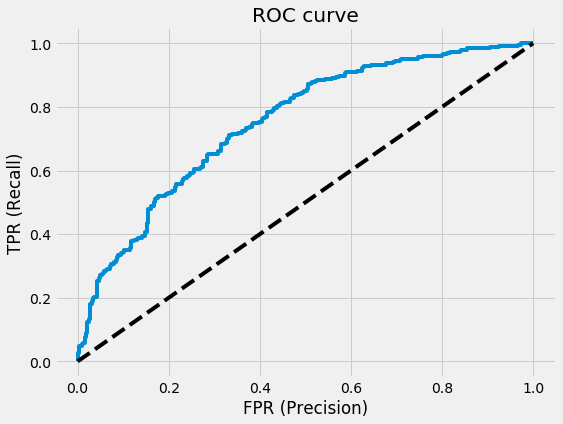

Area under curve (AUC):  0.7510068000264079


In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8,6

# Curve chart - RandomForest
from sklearn.metrics import roc_curve, auc
y_score = rf_final_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

plt.title('ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print('Area under curve (AUC): ', auc(fpr,tpr))

#### Model 1: CountVectorizer and SVM (the long one)

We implement an SVM classifier as our primary model since prior studies (SVM) have also utilized SVM with good results. We will replicate the model using our own feature set and tune parameters.

In [0]:
import time

start_time = time.time()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline, Pipeline

# Instantiate pipeline which will be tuned
pipe = Pipeline([('cvec', CountVectorizer(analyzer='word',
                                           strip_accents='unicode')),
                 ('svm', SVC(kernel='rbf',
                             class_weight='balanced',
                             C=1,
                             probability=True,
                             random_state=42))
                 ])

# Tune hyperparameters
pipe_params = {'cvec__stop_words': (None, 'english'),
               'cvec__ngram_range': ((1,1), (2,2)),
               'cvec__max_df': ((0.5, 0.75, 1.0)),
               'cvec__max_features': (None, 500, 1000, 2000)
               }

if __name__ == "__main__":
  # GridSearch cross-validate to find best parameters for our pipeline
  gs_svm = GridSearchCV(pipe,
                        param_grid=pipe_params,
                        cv=5,
                        n_jobs=-1)
  
  gs_svm.fit(X_train, y_train)
  gs_svm_res = gs_svm.cv_results_

  end_time = time.time()
  total_time = round((end_time - start_time) / 60, 2)

  print("Total time taken: %2f minutes\n" % total_time)
  print(gs_svm.best_params_)
  print("Best score: %4f" % gs_svm.best_score_)
  print("Mean test score: %4f" % np.mean(gs_svm_res.get('mean_test_score')))

  svm_final_model = gs_svm.best_estimator_

SyntaxError: ignored

In [0]:
from sklearn.metrics import confusion_matrix, classification_report 
svm_preds = svm_final_model.predict(X_train)
print(classification_report(y_train, svm_preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1250
           1       1.00      0.98      0.99      1322

    accuracy                           0.99      2572
   macro avg       0.99      0.99      0.99      2572
weighted avg       0.99      0.99      0.99      2572



#### Model 2: TfidfVectorizer and Logit (the quicker one)

We also implemented a logit model for coefficient interpretability

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

start_time = time.time()

pipe = Pipeline([('cvec', CountVectorizer(analyzer='word',
                                          strip_accents='unicode',
                                          stop_words=None)),
                 ('lr', LogisticRegression(solver='liblinear',
                                           random_state=42))])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': ((1,1),(2,2)),
               'cvec__max_df': ((0.5,0.75,1.0)),
               'cvec__max_features': (None,500,1000,2000),
               'lr__C': (0.01, 1.0, 10.0)
               }

if __name__ == "__main__":
  # GridSearch cross-validate to find best parameters for our pipeline
  gs_lr = GridSearchCV(pipe,
                       param_grid=pipe_params,
                       cv=5,
                       n_jobs=-1,
                       return_train_score=True)
  gs_lr.fit(X_train, y_train)
  gs_lr_res = gs_lr.cv_results_

  end_time = time.time()
  total_time = (end_time - start_time) / 60

  print("Total time taken: %2f minutes\n" % total_time)
  print(gs_lr.best_params_)
  print("Best score: %4f" % gs_lr.best_score_)
  print("Mean train score: %4f" % np.mean(gs_lr_res.get('mean_train_score')))
  print("Mean test score: %4f" % np.mean(gs_lr_res.get('mean_test_score')))

  lr_final_model = gs_lr.best_estimator_
  

Total time taken: 36.060445 minutes

{'cvec__max_df': 0.5, 'cvec__max_features': None, 'cvec__ngram_range': (1, 1), 'lr__C': 0.01}
Best score: 0.743994
Mean train score: 0.899527
Mean test score: 0.679425


In [0]:
from sklearn.metrics import confusion_matrix, classification_report 
lr_preds = lr_final_model.predict(X_train)
cnf_matrix = confusion_matrix(y_train, lr_preds)

print(cnf_matrix)
print(classification_report(y_train, lr_preds))

[[1361   13]
 [  53 1362]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1374
           1       0.99      0.96      0.98      1415

    accuracy                           0.98      2789
   macro avg       0.98      0.98      0.98      2789
weighted avg       0.98      0.98      0.98      2789



In [0]:
from sklearn.metrics import confusion_matrix

# Create out-of-sample prediction using RandomForest
y_hat = lr_final_model.predict(X_test)

# Print out the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat)
print(cnf_matrix)

[[250  74]
 [102 272]]


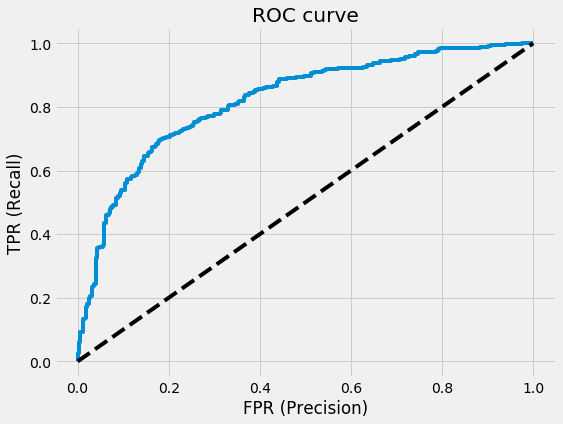

Area under curve (AUC):  0.8201046411830726


In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8,6

# Curve chart - RandomForest
from sklearn.metrics import roc_curve, auc
y_score = lr_final_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

plt.title('ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print('Area under curve (AUC): ', auc(fpr,tpr))

### Final Model

#### Final Model: TfidfVec into SVM 

In [0]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score

y_hat = svm_final_model.predict(X_test)

#print('Accuracy score: ' + str(svm.score(Xtf_test, y_test)))
#print('Recall score: ' + str(recall_score(y_test, preds)))
#print('AUC score: ' + str(roc_auc_score(y_test,preds)))

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
cnf_matrix = confusion_matrix(y_test, y_hat)
# Print the confusion matrix
print(cnf_matrix)

# Print the classification report
print(classification_report(y_test, y_hat))

[[242  71]
 [ 93 238]]
              precision    recall  f1-score   support

           0       0.72      0.77      0.75       313
           1       0.77      0.72      0.74       331

    accuracy                           0.75       644
   macro avg       0.75      0.75      0.75       644
weighted avg       0.75      0.75      0.75       644



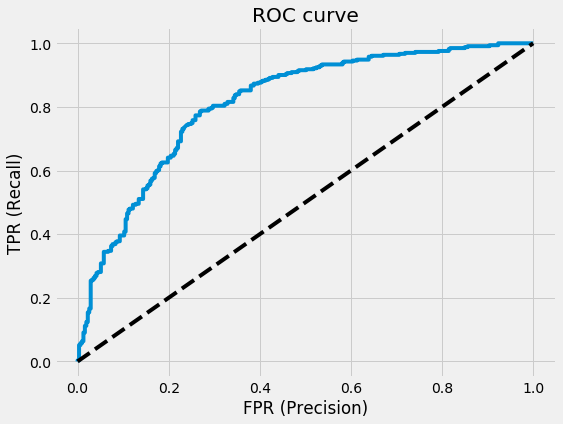

Area under curve (AUC):  0.8119262955705915


In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8,6

# Curve chart - SVM
from sklearn.metrics import roc_curve, auc
y_score = svm_final_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

plt.title('ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print('Area under curve (AUC): ', auc(fpr,tpr))

#### Final Model 2: TfidfVec into Logit

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction import stop_words

# Predict test set using final model
y_hat = lr_final_model.predict(X_test)

# Print the results
#print('Accuracy score: ' + str(lr.score(Xtf_test, y_test)))
#print('Recall score: ' + str(recall_score(y_test, preds)))
#print('AUC score: ' + str(roc_auc_score(y_test, preds)))

In [0]:
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score

# Print out the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat)
print(cnf_matrix)

# Print out the classification report
print(classification_report(y_test, y_hat))

[[242  71]
 [ 77 254]]
              precision    recall  f1-score   support

           0       0.76      0.77      0.77       313
           1       0.78      0.77      0.77       331

    accuracy                           0.77       644
   macro avg       0.77      0.77      0.77       644
weighted avg       0.77      0.77      0.77       644



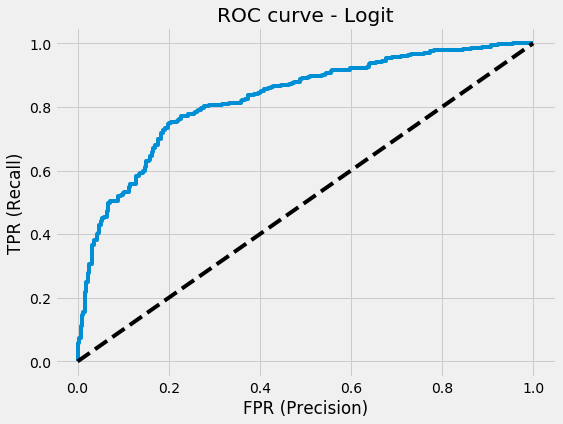

Area under curve (AUC):  0.8260475082767873


In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8,6

# Curve chart - logit
from sklearn.metrics import roc_curve, auc
y_score = lr_final_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

plt.title('ROC curve - Logit')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print('Area under curve (AUC): ', auc(fpr,tpr))

#### Coefficient Analysis

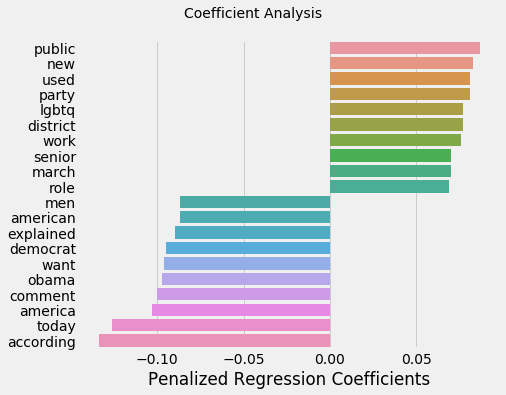

In [0]:
import seaborn as sns

# Create list of logistic regression coefficients 
lr_coef = np.array(lr_final_model.named_steps['lr'].coef_).tolist()
lr_coef = lr_coef[0]

# create dataframe from lasso coef
lr_coef = pd.DataFrame(np.round_(lr_coef,
                                 decimals=3), 
                       lr_final_model.named_steps['cvec'].get_feature_names(),
                       columns = ["penalized_regression_coefficients"])

# sort the values from high to low
lr_coef = lr_coef.sort_values(by = 'penalized_regression_coefficients', 
ascending = False)

# create best and worst performing lasso coef dataframes
df_head = lr_coef.head(10) 
df_tail = lr_coef.tail(10)

# merge back together
df_merged = pd.concat([df_head, df_tail], axis=0)

# plot the sorted dataframe
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.suptitle('Coefficient Analysis', size=14)
ax = sns.barplot(x = 'penalized_regression_coefficients', y= df_merged.index, 
data=df_merged)
ax.set(xlabel='Penalized Regression Coefficients')
plt.tight_layout(pad=3, w_pad=0, h_pad=0)
plt.show()